<a href="https://colab.research.google.com/github/noamZigler/part-2--Technical-Analysis/blob/main/Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Take data of btc vs usd  from binance (code lesson 6 -working whith data)

In [141]:
import requests
import datetime
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [104]:

def make_api_call(base_url, endpoint="", method="GET", **kwargs):
    # Construct the full URL
    full_url = f'{base_url}{endpoint}'

    # Make the API call
    response = requests.request(method=method, url=full_url, **kwargs)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        return response
    else:
        # If the request was not successful, raise an exception with the error message
        raise Exception(f'API request failed with status code {response.status_code}: {response.text}')



In [140]:
start_date = datetime.datetime(2023, 1, 1).isoformat()
end_date = datetime.datetime(2024, 1, 1).isoformat()
curr_time=start_date
api_key='c9389f08-b40d-4d7d-b85d-5ba3c0cd9661'
base_url = 'https://rest.coinapi.io/v1'
method = 'GET'
endpoint = '/ohlcv/BINANCE_SPOT_BTC_USDT/history'
params = {
    "period_id": "30MIN",  # 30-minute intervals
    "time_start": start_date,
    "time_end": end_date,
    "apikey": api_key
}
response = make_api_call(base_url, endpoint, method, params=params).json()
opening_prices = []
for data_point in response:
    opening_prices.append({
        'time_open': data_point['time_open'],
        'price_open': data_point['price_open']
    })
df = pd.DataFrame(opening_prices)
df['time_open'] = pd.to_datetime(df['time_open'])
#df['price_open']=df['price_open'].astype(int)
df.set_index('time_open', inplace=True)


# Binance is restricted in Israel , we take the data from coin api and filtered the data so that the source of the data will be only from binance and by that achieve the same goal.

In [134]:
def fetch_all_data(start_date, end_date, api_key, base_url, endpoint, params):
    all_data = []
    current_start = start_date
    while current_start < end_date:
        # Set time_start and time_end for the current request

        params["time_start"] = current_start.isoformat()

        # Calculate next start time, considering API limit
        next_start = current_start + datetime.timedelta(days=3)  # Assuming API limit of 1 year

        # Adjust if next_start exceeds end_date
        params["time_end"] = min(next_start, end_date).isoformat()

        # Make the API call
        response = make_api_call(base_url, endpoint, method="GET", params=params).json()
        binance_data = [data_point for data_point in response if isinstance(data_point, dict) and data_point.get('exchange') == 'BINANCE']
        # Append data to the list
        all_data.extend(response)

        # Update current_start for the next iteration
        current_start = next_start

        # Optional: Add a small delay to avoid rate limiting
        time.sleep(1)

    return all_data





In [138]:
start_date = datetime.datetime(2023, 1, 1)
end_date = datetime.datetime(2024, 1, 1)

all_data = fetch_all_data(start_date, end_date, api_key, base_url, endpoint, params)
df = pd.DataFrame(all_data)
df['time'] = pd.to_datetime(df['time_open']).dt.strftime('%Y/%m/%d %H:%M')
df['price']=df['price_open'].astype(int)
new_df = df[['time', 'price']]
new_df.set_index('time', inplace=True)
new_df.to_csv('crypto_data.csv')


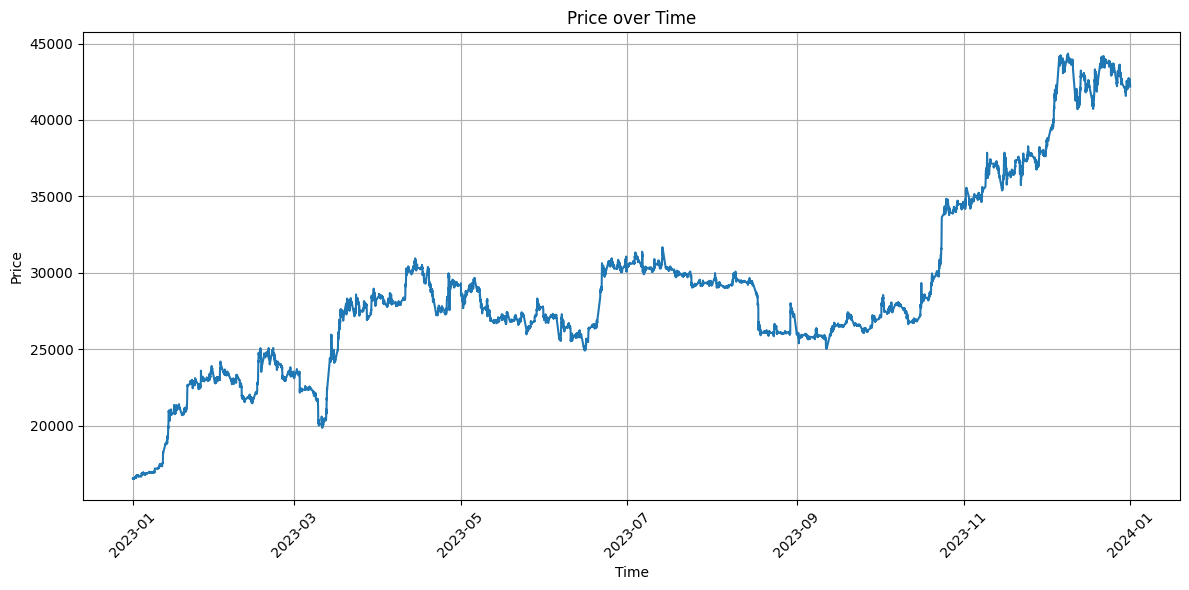

In [139]:
new_df.index = pd.to_datetime(new_df.index)

# Plot the 'price' column against the 'time' index
plt.figure(figsize=(12, 6))  # Adjust figure size if needed
plt.plot(new_df.index, new_df['price'])
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Price over Time")
plt.grid(True)  # Add grid lines if desired
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [ ]:
#calculate technical indicators from the video and explain the reason behing each one

#   STC indicator-  length =80  fast length=27  red and green max opacity-> confirming the entry with the second indicator
#   ut bot - key=2 ,ATR(Average True Range & moving average-based trend filter)=1,sytle= sell if above     &&   ut bot - key=2 ,ATR(Average True Range & moving average-based trend filter)=300,sytle= buy if bellow

# when we get buy signal from ut bot we check that stc is under the green and when his graph changes the slope from negative to positive we buy

#  when we get sell signal from ut bot we check that stc is above the red and when his graph changes the slope from positive to negative we sell


# buy trades -stop loss below the low and take profit twice the distance of stop loss
#sell trades- stop loss above the high and take profit twice as much lower than the high

**STC indicator**: STC (Schaff Trend Cycle) Indicator is a technical analysis tool used to identify trends and trend reversals in financial markets. It was developed by Doug Schaff and is considered an improvement over traditional momentum indicators like the MACD (Moving Average Convergence Divergence).
Unlike the MACD, which only relies on moving averages, the STC incorporates cycle analysis to improve trend identification.

advantages:  
*   Faster signals than MACD due to the cycle component.
*   Reduces lag compared to other momentum indicators.
*   Effective in spotting early trend reversals.
*   Works well in both trending and ranging markets.

disadvantages:  
*   Can generate false signals in choppy or sideways markets.
*   Works best when combined with other indicators like support/resistance levels or volume analysis.
*    May require fine-tuning of its parameters for different assets.


**UT Bot Indicator-Ultimate Trend Bot**:
The UT Bot Indicator is a trend-following indicator that provides buy and sell signals based on price movements. It is inspired by SuperTrend but is optimized for better accuracy in trend identification.

uses a moving average to determine the general direction of the trend and filters out noise to avoid false signals.

buy signal is generated when the price closes above the UT Bot level.
sell signal is generated when the price closes below the UT Bot level.

multiplier:
* Adjusts sensitivity to price changes.
* higher ATR multiplier makes the signals less frequent but more reliable.
* lower ATR multiplier gives more signals but might result in more false breakouts.

formula: UT Bot Line = Moving Average ± ATR Multiplier

Advantages:
* Trend-Following: Helps traders stay in strong trends.
* Reduces Noise: Uses ATR to filter out false signals.
* Works in Multiple Timeframes: Can be applied in stocks, crypto, forex, etc.
* Good for Swing & Trend Trading: Less lag compared to SuperTrend.

Disadvantages:
* Not ideal for ranging markets (can give false signals).
* Requires fine-tuning of ATR multiplier for different assets.
* Works best with additional confirmation (e.g., RSI, MACD).

In [144]:
def MACD(data, short_ema=23, long_ema=50, signal_ema=9):
    data['ShortEMA'] = data['Close'].ewm(span=short_ema, adjust=False).mean()
    data['LongEMA'] = data['Close'].ewm(span=long_ema, adjust=False).mean()
    data['MACD'] = data['ShortEMA'] - data['LongEMA']
    return data['MACD']
def Stochastic_MACD(data,stoch_period):
    data['Lowest_MACD'] = data.rolling(window=stoch_period).min()
    data['Highest_MACD'] = data.rolling(window=stoch_period).max()
    data['Stoch_K'] = 100 * ((data - data['Lowest_MACD']) / (data['Highest_MACD'] - data['Lowest_MACD']))
    return data['Stoch_K']

def stc_indicator(data, short_ema=23, long_ema=50, stoch_period=10, smooth_period=10):
    data['MACD']=MACD(data,short_ema=short_ema, long_ema=long_ema)
    data['Stoch_K']=Stochastic_MACD(data['MACD'],stoch_period)
    # Smooth the Stochastic %K using EMA
    data['STC'] = data['Stoch_K'].ewm(span=smooth_period, adjust=False).mean()
    return data['STC']


**Reason behind STC:**  to complete

In [ ]:

#  ATR (Average True Range)
def ATR(data, period=14):
    data['High-Low'] = data['High'] - data['Low']
    data['High-Close'] = abs(data['High'] - data['Close'].shift(1))
    data['Low-Close'] = abs(data['Low'] - data['Close'].shift(1))
    data['TR'] = data[['High-Low', 'High-Close', 'Low-Close']].max(axis=1)
    data['ATR'] = data['TR'].rolling(window=period).mean()
    return data

def ut_bot_indicator(data, atr_multiplier=1.5, atr_period=14, ma_period=50):
    data = ATR(data, atr_period)
    # Compute Moving Average
    data['MA'] = data['Close'].rolling(window=ma_period).mean()

    data['UT_Bot_Upper'] = data['MA'] + (data['ATR'] * atr_multiplier)
    data['UT_Bot_Lower'] = data['MA'] - (data['ATR'] * atr_multiplier)
    data['Buy_Signal'] = (data['Close'] > data['UT_Bot']) & (data['Close'].shift(1) <= data['UT_Bot'].shift(1))
    data['Sell_Signal'] = (data['Close'] < data['UT_Bot']) & (data['Close'].shift(1) >= data['UT_Bot'].shift(1))
    return data


**Reason behind UT BOT:** to complete

In [ ]:
#compare my data to the data of the indicators in trading view

In [ ]:
#describe the trade strategy and the reason behind it

In [ ]:
#implement the strategy and measure its performance

In [ ]:
#choose one parameter and explain how it is affecting the indicator, perform section 5 again with a different value

In [ ]:
#present the performance on a graph

In [ ]:
#compare the assumptions and the real results